In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import matplotlib.patches as patches
import io
import xarray as xr

from numpy.polynomial import polynomial as P
from utils import u_plot

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
MREGIONS = {
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'JJA', [5,6,7,8,9]], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china', 'JJA', [5,6,7,8,9]], # 4
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'JJA', [5,6,7,8,9]], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india', 'JJA', [5,6,7,8,9]], # 7
 'WAf_N' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'JJA', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'WAf_S' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,7,9], 'WAf', 'JJA', [5,6,7,8,9]],
 'australia_S' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'DJF', [11,12,1,2,3]], # 3
 'australia_N' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -17,-15], 'australia', 'DJF', [11,12,1,2,3]],
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'DJF', [11,12,1,2,3]], # 10
 'sub_SA_S' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'DJF', [11,12,1,2,3]],  # 16
 'sub_SA_N' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-28,-22], 'sub_SA', 'DJF', [11,12,1,2,3]]  # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]
box = MREGIONS['australia_N'][0]

In [5]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = True
    xl.ylines=True
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    

    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [6]:
import matplotlib.patches as patches
def draw_map_pixel(ax, t, lat, lon, title='', clabel='', cmap='RdBu_r', **kwargs):
   
    plt.pcolormesh(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    ax.coastlines()
    
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', linestyle='dashed');
    #ax.set_xticks(np.arange(-140,161,20), minor=True)
    plt.grid(which='minor')
    
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = True
    xl.ylines=True
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='k', linewidth=0.5);
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [7]:
def filter_corr_month(ds):
    ds = np.abs(ds.where(((ds.latitude>=0) & (ds['r']<-0.35)) | ((ds.latitude<=0) & (ds['r']>0.35))).load())
    ds = ds.where(ds>=0.1, other=-9999)
    ccount = ds.where(ds>=0.1).count(dim='month')
    cds = ds.argmax(dim='month').load()+1
    cds = cds.where(ccount>=2)
    cds = cds.sel(longitude=slice(-130, 160))
    #cds = cds.where(((cds.latitude>=0) & cds['r'].isin([4,5,6,7,8,9,10])) | ((cds.latitude<=0) & cds['r'].isin([10,11,12,1,2,3]))).load()
    return cds

In [58]:
corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations/sh_versus_ushear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')

In [59]:
cds = filter_corr_month(corr_ds)

In [60]:
pval = corr_ds['pval'].min(dim='month').load()

In [62]:
norm = u_plot.discrete_cmap_norm([1,4,7,10,13], 'jet')

In [13]:
smask = xr.open_dataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/ERA5_monthly_0.7deg_static.nc')['lsm'].squeeze()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


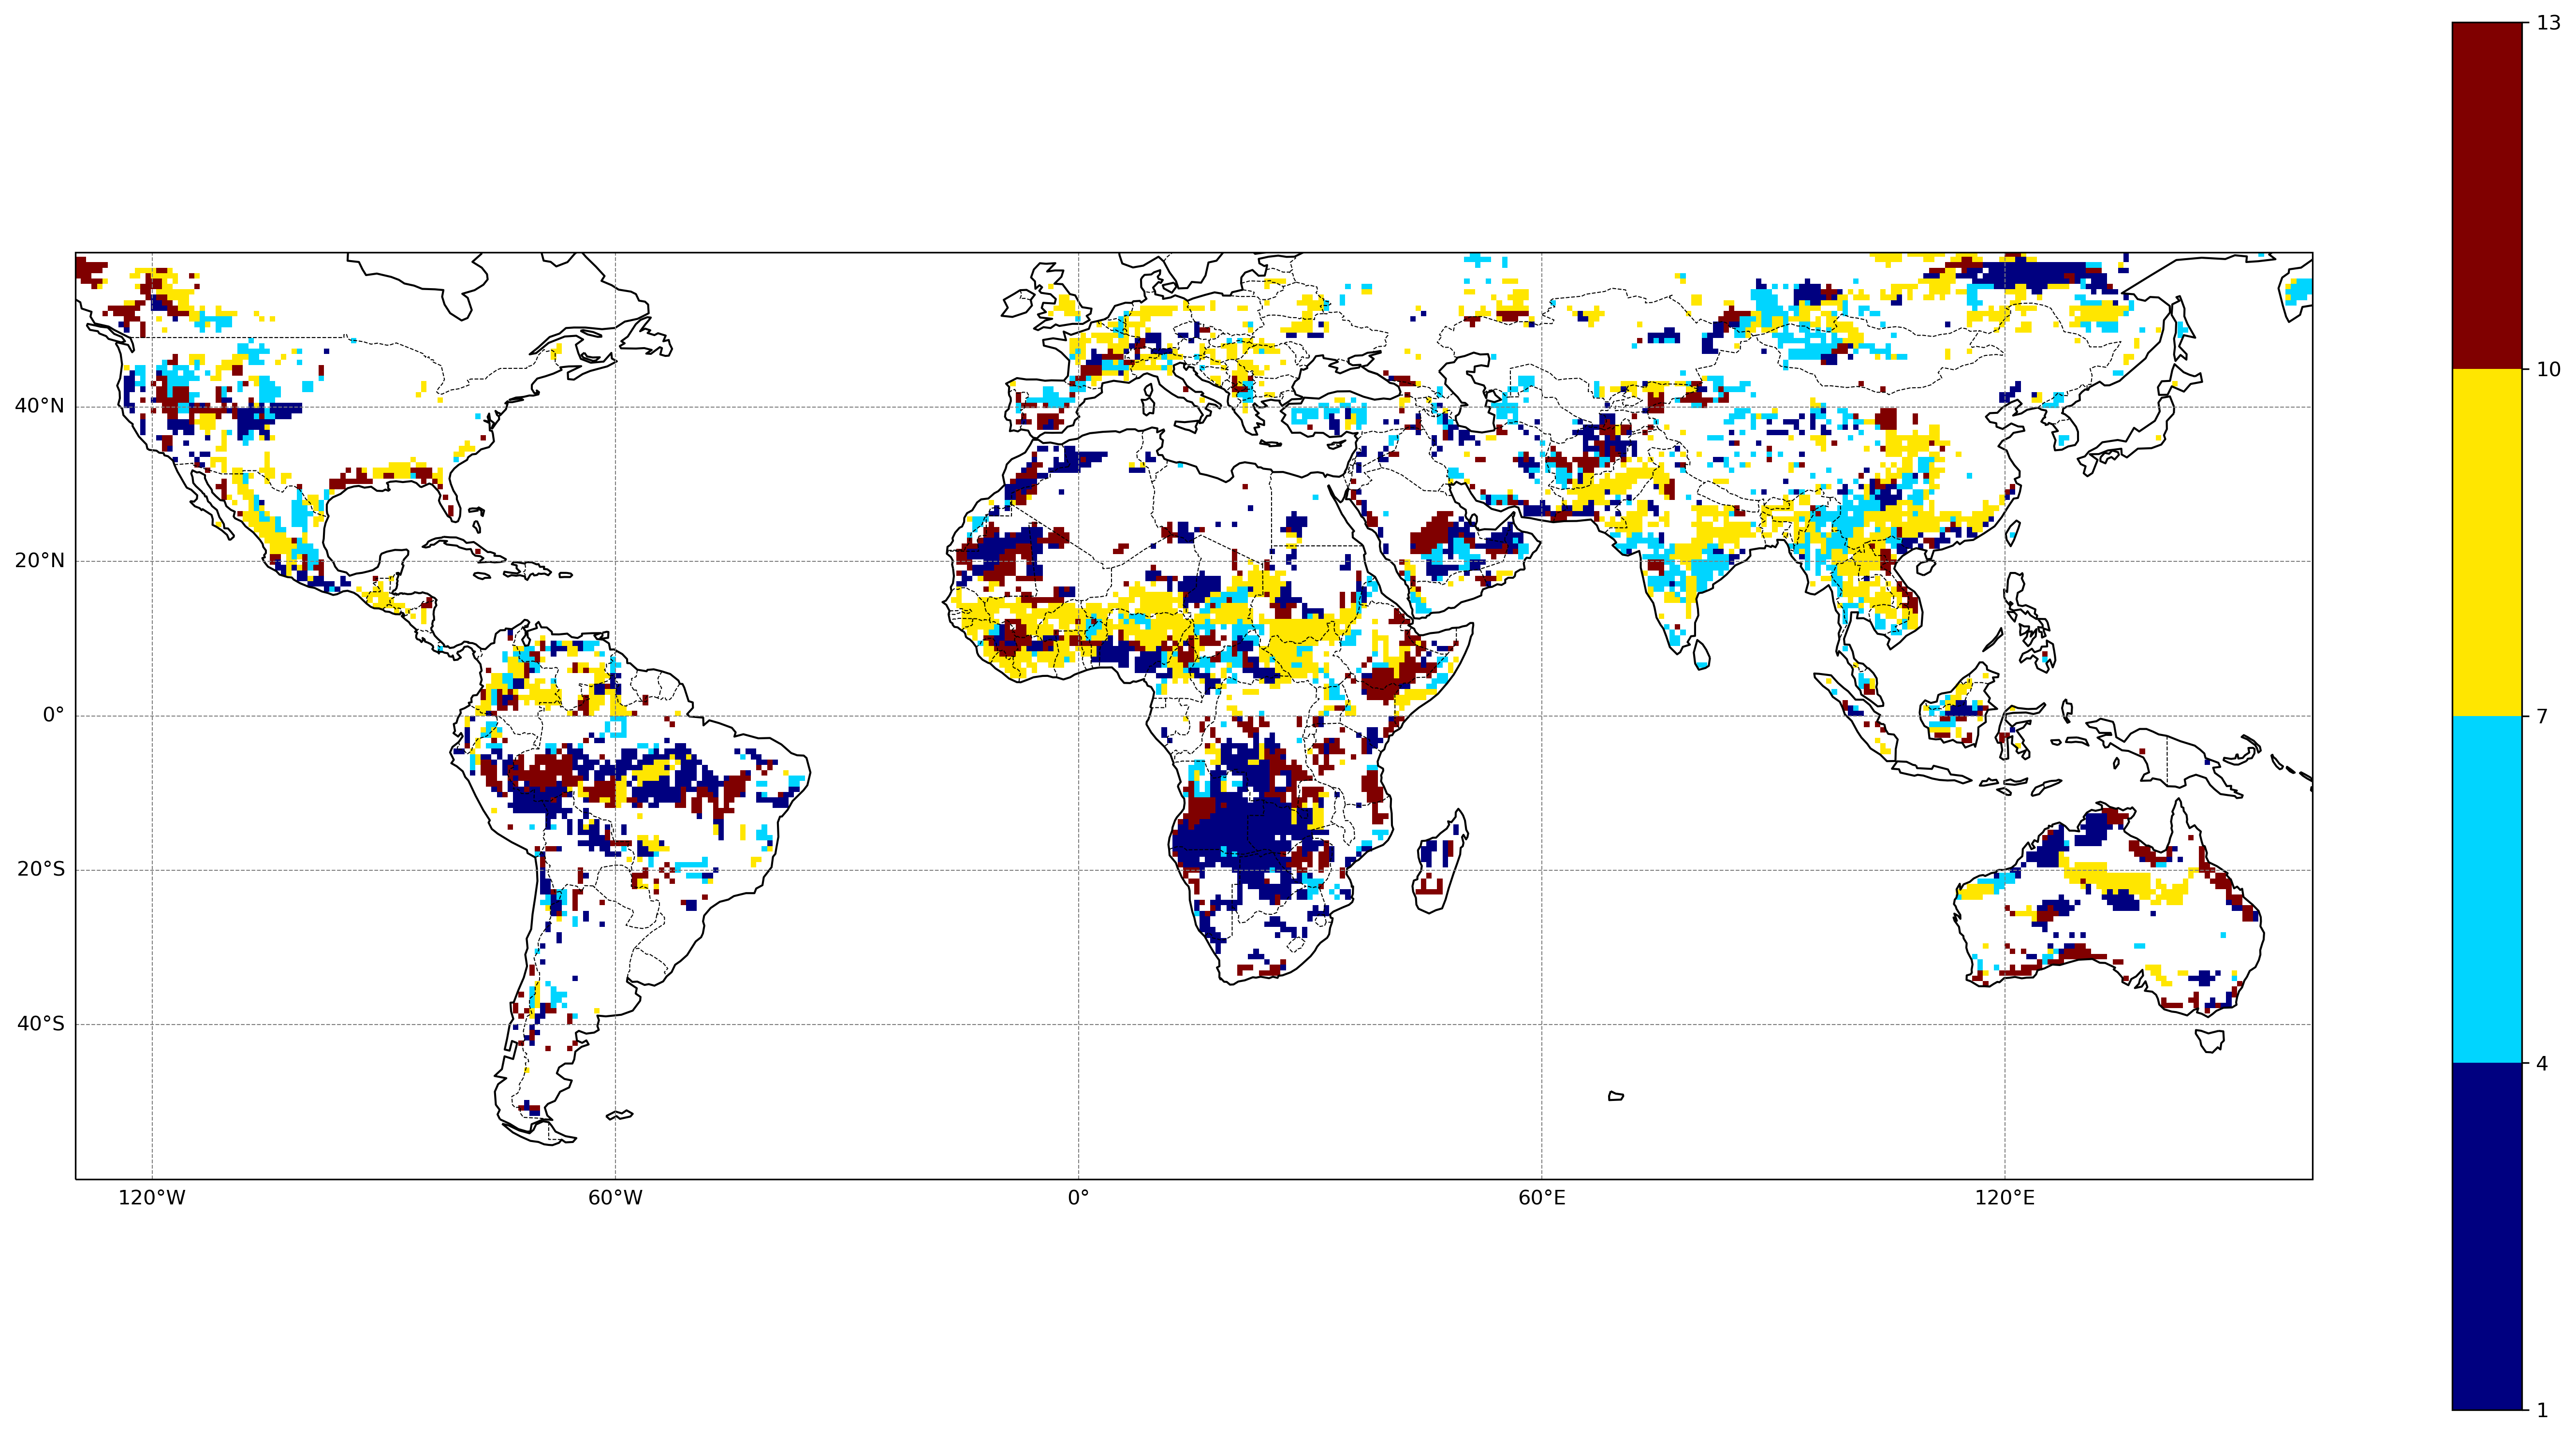

In [64]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
draw_map_pixel(ax, cds['r'].where((pval<0.01) & (smask>0.98)), cds.latitude, cds.longitude, title='', clabel='', cmap='jet', norm=norm)
ax.set_ylim(-60,60)
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/t2_ushear_correlation_map_2monthPyear.png')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defi

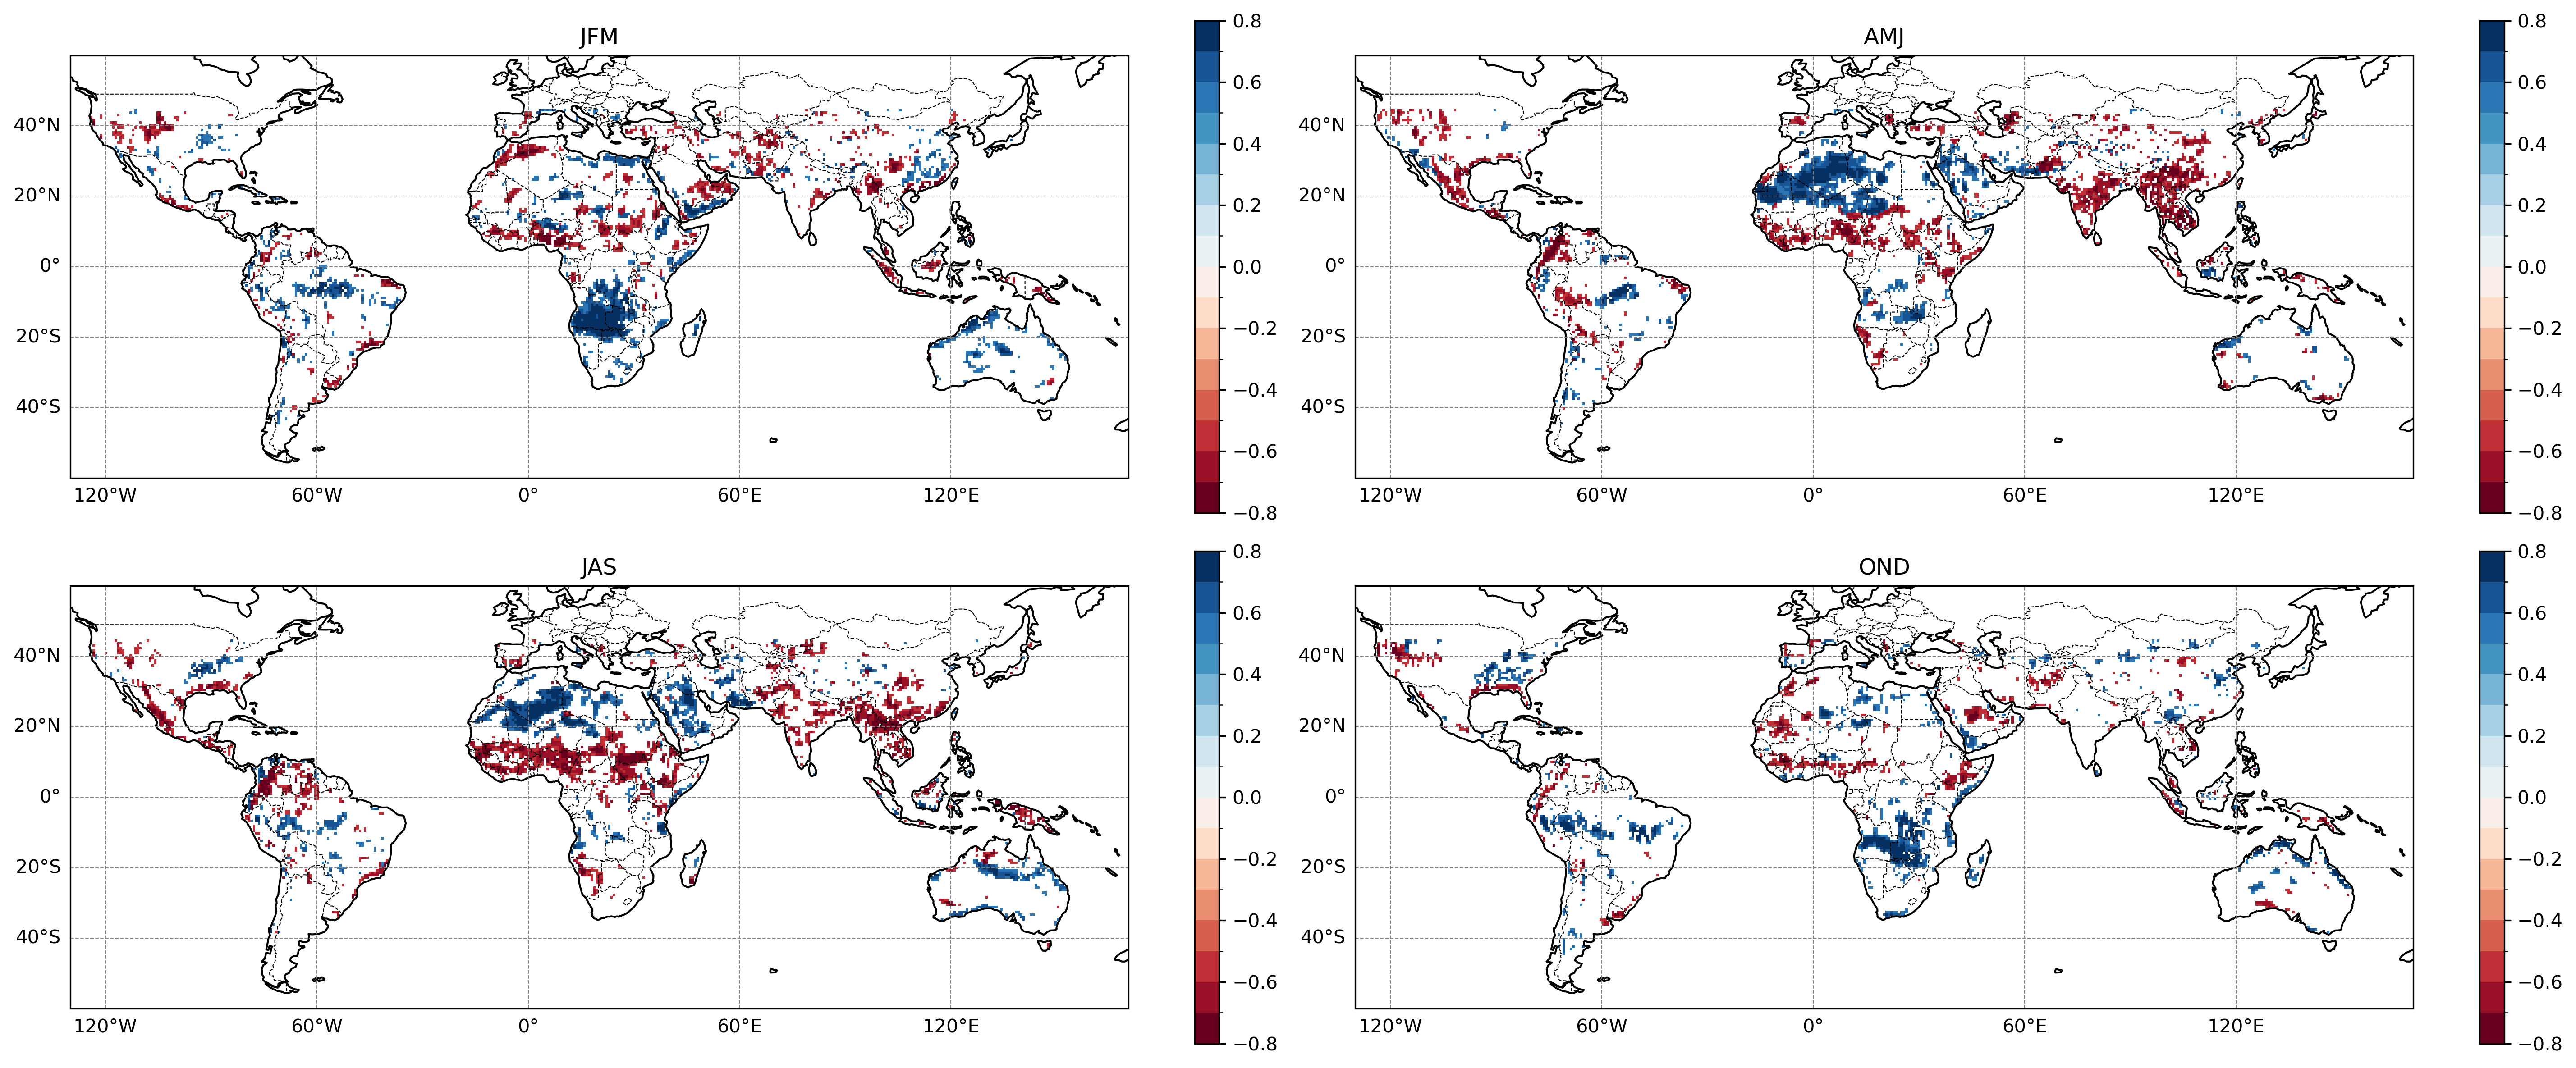

In [19]:
corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new/sh_versus_ushear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')


#corr_month['r'].values[corr_month.latitude.values<0] = (corr_month['r'].values[corr_month.latitude.values<0])*-1
titles = ['JFM', 'AMJ', 'JAS', 'OND']

f = plt.figure(figsize=(20,8), dpi=300)
for idx, cs in enumerate([(1,2,3), (4,5,6), (7,8,9), (10,11,12)]):
    norm = u_plot.discrete_cmap_norm(np.arange(-0.8,0.81,0.1), 'jet')

    corr_month = corr_ds['r'].sel(month=corr_ds.month.isin(cs)).mean('month')
    
    corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    corr_abs = np.abs(corr_months['r']).max('month')
    corr_pval = corr_months['pval'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
    corr_max = corr_months['r'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
   
    
    #corr_month['r'].where((corr_month['pval']<0.25) & (smask>0.98))
    

    
    ax = f.add_subplot(2,2,idx+1, projection=ccrs.PlateCarree())
    draw_map_pixel(ax, corr_max.where((corr_pval<0.01) & (smask>0.98)), corr_month.latitude, corr_month.longitude, title='', clabel='', cmap='RdBu', norm=norm) #corr_month['pval']<0.01) &
    ax.set_ylim(-60,60)
    plt.title(titles[idx])
    plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/sh_ushear_correlation_map_corrfac_meridional.png')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defi

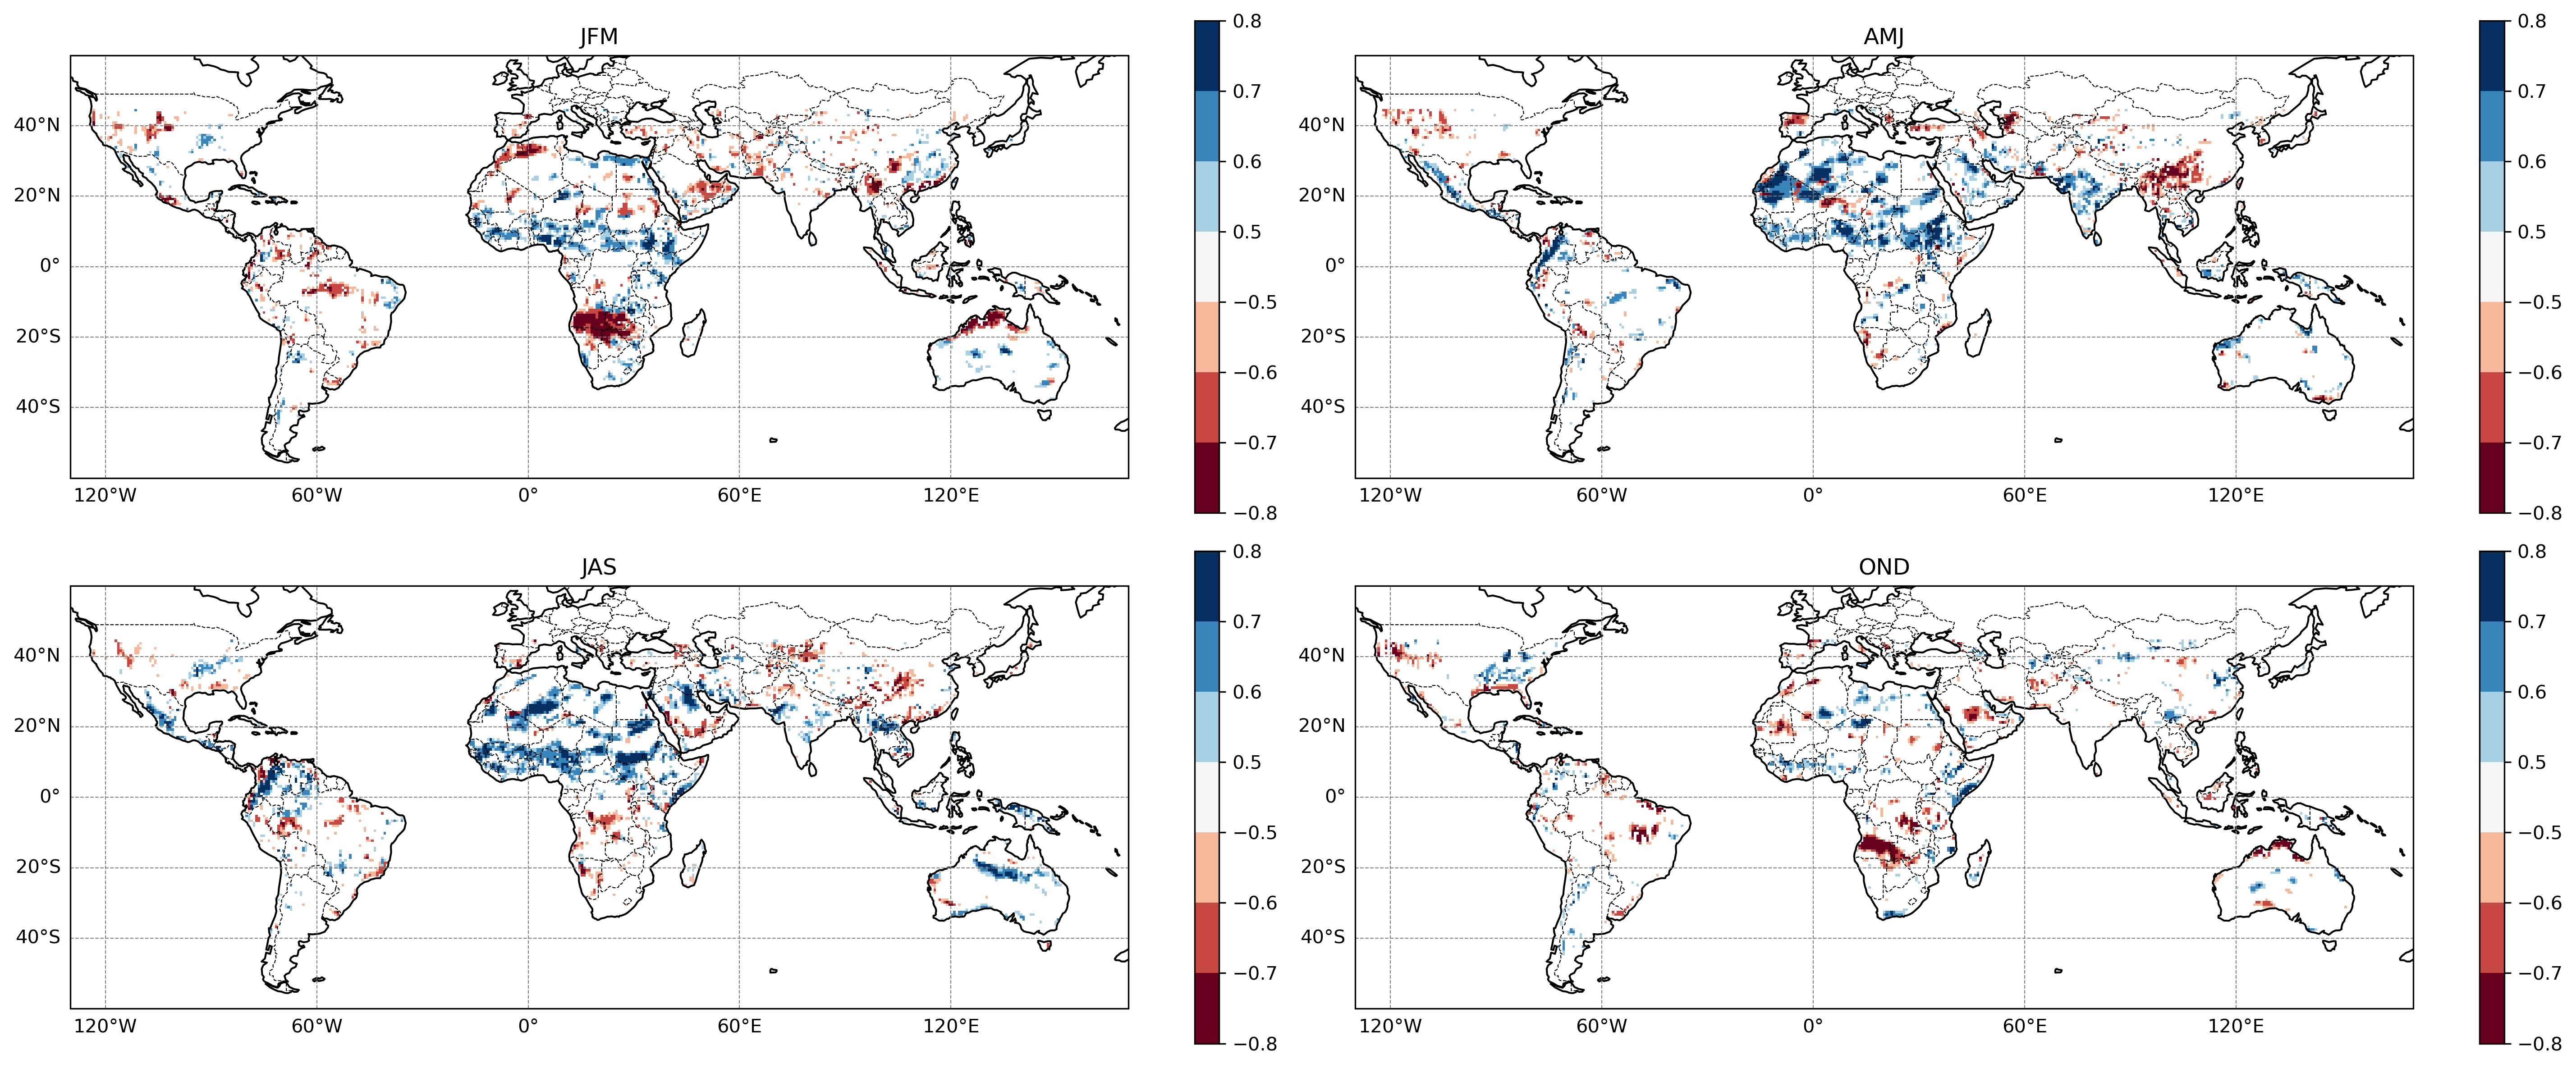

In [23]:
corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new/sh_versus_shear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')


#corr_month['r'].values[corr_month.latitude.values<0] = (corr_month['r'].values[corr_month.latitude.values<0])*-1
titles = ['JFM', 'AMJ', 'JAS', 'OND']

f = plt.figure(figsize=(20,8), dpi=300)
for idx, cs in enumerate([(1,2,3), (4,5,6), (7,8,9), (10,11,12)]):
    norm = u_plot.discrete_cmap_norm([-0.8,-0.7,-0.6,-0.5,0.5,0.6,0.7,0.8], 'jet')

    corr_month = corr_ds.sel(month=corr_ds.month.isin(cs)).mean('month')
    
    corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    corr_abs = np.abs(corr_months['r']).max('month')
    corr_pval = corr_months['pval'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
    corr_max = corr_months['r'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
   
    
    #corr_month['r'].where((corr_month['pval']<0.25) & (smask>0.98))
    

    
    ax = f.add_subplot(2,2,idx+1, projection=ccrs.PlateCarree())
    draw_map_pixel(ax, corr_max.where((corr_pval<0.01) & (smask>0.98)), corr_month.latitude, corr_month.longitude, title='', clabel='', cmap='RdBu', norm=norm) #corr_month['pval']<0.01) &
    ax.set_ylim(-60,60)
    plt.title(titles[idx])
    plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/sh_ushear_correlation_map_corrfac_meridional.png')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


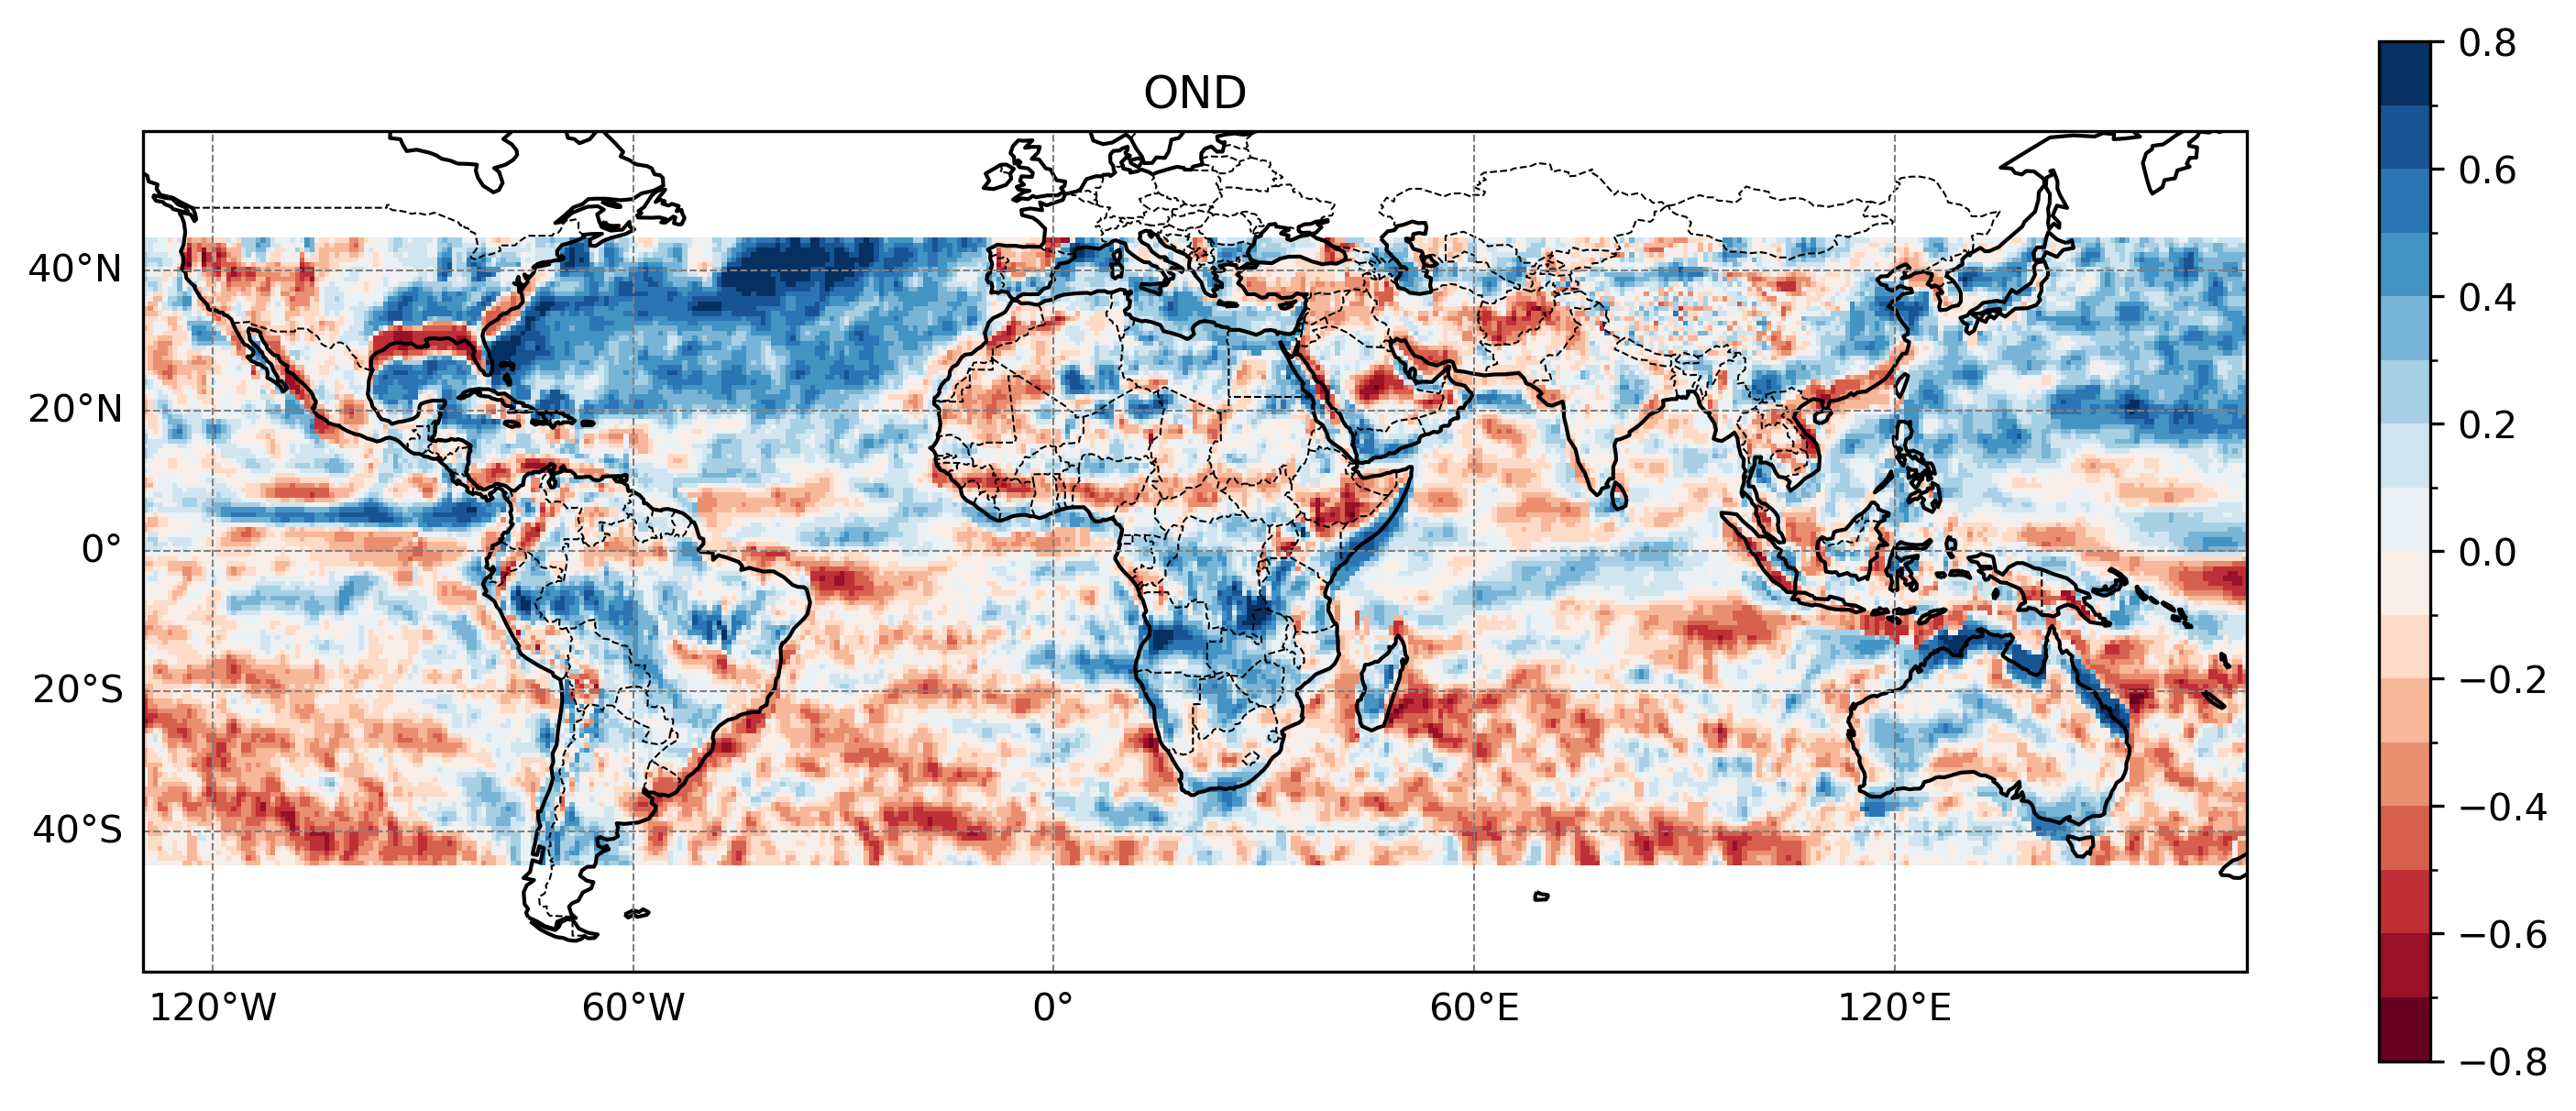

In [16]:
corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new/sh_versus_ushear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')


#corr_month['r'].values[corr_month.latitude.values<0] = (corr_month['r'].values[corr_month.latitude.values<0])*-1
titles = ['JFM', 'AMJ', 'JAS', 'OND']

coll=[]

f = plt.figure(figsize=(20,8), dpi=300)
for idx, cs in enumerate([(1,2,3), (4,5,6), (7,8,9), (10,11,12)]):
    norm = u_plot.discrete_cmap_norm(np.arange(-0.8,0.81,0.1), 'jet')

    corr_month = corr_ds.sel(month=corr_ds.month.isin(cs)).mean('month')
    
    corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    corr_abs = np.abs(corr_months['r']).max('month')
    corr_pval = corr_months['pval'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
    corr_max = corr_months['r'].where(np.abs(corr_months['r'])==corr_abs).mean('month')
   
    
    coll.append(corr_max.where((corr_pval<0.01) & (smask>0.98)))
    
merge = xr.concat(coll, dim='idx')

corr_max = merge.mean('idx')
    
ax = f.add_subplot(2,2,idx+1, projection=ccrs.PlateCarree())
draw_map_pixel(ax, corr_month['r'] , corr_month.latitude, corr_month.longitude, title='', clabel='', cmap='RdBu', norm=norm) #corr_month['pval']<0.01) &
ax.set_ylim(-60,60)
plt.title(titles[idx])
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/sh_ushear_correlation_map_corrfac_meridional.png')